In [1]:
# The following code is from Zhaoyi Zhang.
# I tested it to see if it works for trees with 4 taxa
from math import comb
from itertools import combinations, islice
import time

from Bio import Phylo
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 12

In [2]:
trees = Phylo.parse('data/4taxa_trees.tre', 'newick')
next(trees)
next(trees)
tree = next(trees)

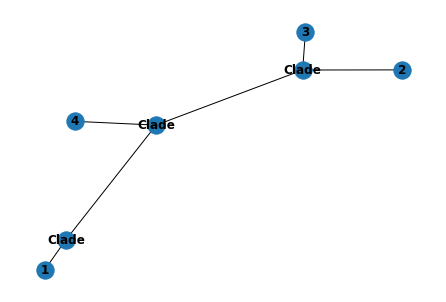

In [3]:
import networkx as nx
G = Phylo.to_networkx(tree)
nx.draw(G, with_labels=True, font_weight='bold')

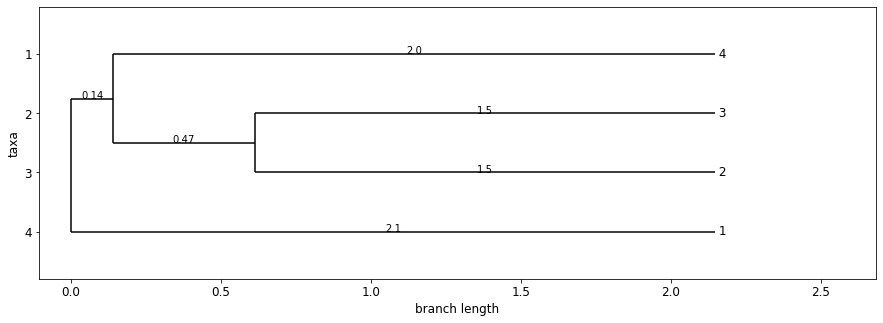

In [4]:
def format_branch_length(node):
    if node.branch_length:
        return f'{node.branch_length:.2}'
    else:
        return ''

fig, ax = plt.subplots(figsize=(15, 5))
Phylo.draw(tree, branch_labels=format_branch_length, axes=ax)

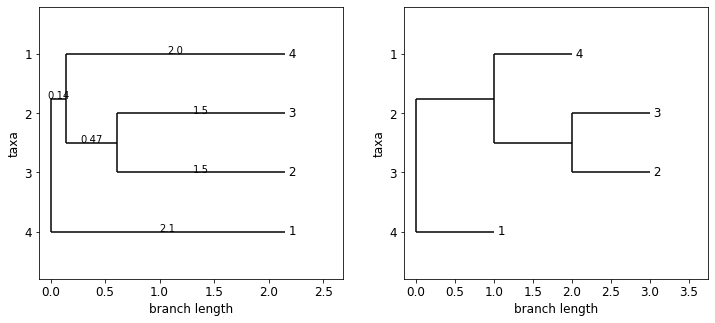

In [5]:
# figures for debugging
def clear_branch_length(clade):
    if clade.clades:
        for c in clade.clades:
            c.branch_length = 1
            clear_branch_length(c)

def draw_equal_branch_length(tree, axes=None):
    t = Phylo.BaseTree.Tree.from_clade(tree.clade)
    clear_branch_length(t.clade)
    Phylo.draw(t, axes=axes)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
Phylo.draw(tree, axes=ax0, do_show=False, branch_labels=format_branch_length)
draw_equal_branch_length(tree, ax1)

In [6]:
def get_direct_children(clade, res=None):
    '''
    get direct children of each clade
    '''
    if res == None:
        res = {}
    res[clade] = []
    if len(clade.clades) == 0:
        return
    for c in clade.clades:
        res[clade].append(c)
        get_direct_children(c, res)
    return res

def expand_direct_children(res):
    '''
    expand direct children of each clade into descendants
    '''
    res_expand = {}
    for k, v in reversed(res.items()):
        res_expand[k] = []
        for c in v:
            if c.name and str.isdigit(c.name):
                res_expand[k].append(c)
            else:
                res_expand[k].extend(res_expand[c])
    return res_expand

def get_descendants(clade):
    '''
    get descendants of each clade in the `clade`
    '''
    res = get_direct_children(clade)
    return expand_direct_children(res)

def print_children(res):
    def get_name_or_length(c):
        return c.name or (c.branch_length and f'{c.branch_length:.2}')
    for k, v in res.items():
        print(get_name_or_length(k), '\t',
              list(map(lambda c: get_name_or_length(c), v)))
        
def desc_to_length(descendants):
    res = []
    for parent, desc in descendants.items():
        if desc:
            res.append(([d.name for d in desc], parent.branch_length))
        else:
            res.append((parent.name, parent.branch_length))
    return res

In [7]:
children = get_direct_children(tree.clade)
print_children(children)

None 	 ['0.14', '1']
0.14 	 ['4', '0.47']
4 	 []
0.47 	 ['3', '2']
3 	 []
2 	 []
1 	 []


In [8]:
descendants = get_descendants(tree.clade)
print_children(descendants)

1 	 []
2 	 []
3 	 []
0.47 	 ['3', '2']
4 	 []
0.14 	 ['4', '3', '2']
None 	 ['4', '3', '2', '1']


In [9]:
desc_to_length(descendants)

[('1', 2.146816),
 ('2', 1.534422),
 ('3', 1.534422),
 (['3', '2'], 0.471769),
 ('4', 2.006191),
 (['4', '3', '2'], 0.140625),
 (['4', '3', '2', '1'], None)]

$$
\begin{align}
2^{n} &= \sum_{i=0}^{n} \binom{n}{i} \\
bipartitions &= \frac{1}{2} \sum_{i=1}^{n-1} \binom{n}{i} \\
&= \frac{1}{2} \left(\sum_{i=0}^{n}{\binom{n}{i}} - \binom{n}{0} - \binom{n}{n}\right) \\
&= \frac{1}{2} \left(2^{n} - 2\right) \\
&= 2^{n-1} - 1
\end{align}
$$

In [10]:
for n in range(1, 100):
    assert sum(comb(n, i) for i in range(1, n)) // 2 == 2**(n-1) - 1

In [11]:
def num_bipartitions(n):
    '''
    summing from C(n, 1) to C(n, n-1) and divided by 2
    C(n, 1) is a|bc..n, b|ac..n, n|ab..m
    C(n, n-1) is bc..n|a, ac..n|b, ab..m|n
    C(n, 0) and C(n, n) are not possible
    '''
    return 2**(n-1) - 1

def show_bipartitions(n, show_section=False, start=0, end=None):
    idx_width = len(str(num_bipartitions(n)))
    node_width = len(str(n))
    idx = 0
    u = set(range(1, n + 1))
    print('idx\tpartition')
    for i in range(1, n//2+1):
        if show_section:
            print(f'{i}/{n-i}')
            
        iterable = combinations(range(1, n + 1), i)
        if i == n - i:
            iterable = islice(iterable, comb(n, i) // 2)
            
        for l in iterable:
            if start <= idx and (end == None or idx <= end):
                print(f'{idx:{idx_width}}', end='\t')
                for e in l:
                    print(f'{e:{node_width}}', end=' ')
                print('|', end=' ')
                for e in u - set(l):
                    print(f'{e:{node_width}}', end=' ')
                print()
            idx += 1

def show_bipartition(n, idx):
    show_bipartitions(n, start=idx, end=idx)

show_bipartitions(4)
show_bipartition(4, idx=5)

idx	partition
0	1 | 2 3 4 
1	2 | 1 3 4 
2	3 | 1 2 4 
3	4 | 1 2 3 
4	1 2 | 3 4 
5	1 3 | 2 4 
6	1 4 | 2 3 
idx	partition
5	1 3 | 2 4 


In [12]:
class BipartitionEnc():
    def __init__(self, n):
        self.n = n
        self.b = num_bipartitions(n)
        
        self.idx_offset = {}
        self.idx_offset[1] = 0
        for i in range(2, n + 1):
            self.idx_offset[i] = comb(n, i - 1) + self.idx_offset[i - 1]
            
        self.u = set(range(1, n + 1))

    def _rank(self, desc):
        k = len(desc)
        rank = comb(self.n, k)
        for i, d in enumerate(sorted(desc)):
            rank -= comb(self.n - d, k - i)
        return rank

    def get_idx_from_desc(self, desc):
        desc = [int(d) for d in desc]
        if len(desc) > self.n//2:
            desc = self.u - set(desc)
        offset = self.idx_offset[len(desc)]
        rk = self._rank(desc) + offset - 1
        if rk >= self.b:
            rk = 2 * self.b - 1 - rk
        return rk
    
    def encode(self, tree, return_desc=False):
        t_nodes = tree.get_terminals()
        if len(t_nodes) != self.n:
            raise Exception(f'Expected {self.n} terminal nodes, but the tree has {len(t_nodes)}')
        encoding = []
        descendants = get_descendants(tree.clade)
        res = desc_to_length(descendants)
        for desc, branch_length in res:
            if len(desc) != self.n:
                idx = self.get_idx_from_desc(desc)
                if return_desc:
                    encoding.append((desc, idx, branch_length))
                else:
                    encoding.append((idx, branch_length))
        return encoding

In [13]:
be = BipartitionEnc(4)
be.encode(tree)

[(0, 2.146816),
 (1, 1.534422),
 (2, 1.534422),
 (6, 0.471769),
 (3, 2.006191),
 (0, 0.140625)]

In [ ]:
## Code for ploting trees
